# RCNN on Fisheye
We have three methods to solve this fisheye detection problem:

Method I:
1. Run pretrained RCNN model directly on testing dataset.
2. We collect metrics for comparison with other models.

Method II:
1. Augment fisheye images a little bit for improving detections
2. Train RCNN detector directly on fisheye frames
3. Map predicted boxes back to fisheye coordinates

## Method I: Running Pretrained RCNN directly

### Imports

In [1]:
import torch
from torchvision.datasets import coco
import os
import numpy as np
import random
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
import cv2

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Training device', device)

Training device cuda


### Loading dataset

In [3]:
from google.colab.drive import mount
mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
# ! unzip /content/gdrive/MyDrive/datasets/FishEye8k/Fisheye8K.zip -d /content/gdrive/MyDrive/datasets/FishEye

In [5]:
DATA_PATH = '/content/gdrive/MyDrive/datasets/FishEye8k/'
TRAIN_PATH = os.path.join(DATA_PATH, 'train', 'images')
TRAIN_ANNOT = os.path.join(DATA_PATH, 'train', 'train.json')
TEST_PATH = os.path.join(DATA_PATH, 'test', 'images')
TEST_ANNOT = os.path.join(DATA_PATH, 'test', 'test.json')

In [6]:
! ls {DATA_PATH}

Fisheye8K.zip  images.zip  test  train


Plotting some random images from dataset

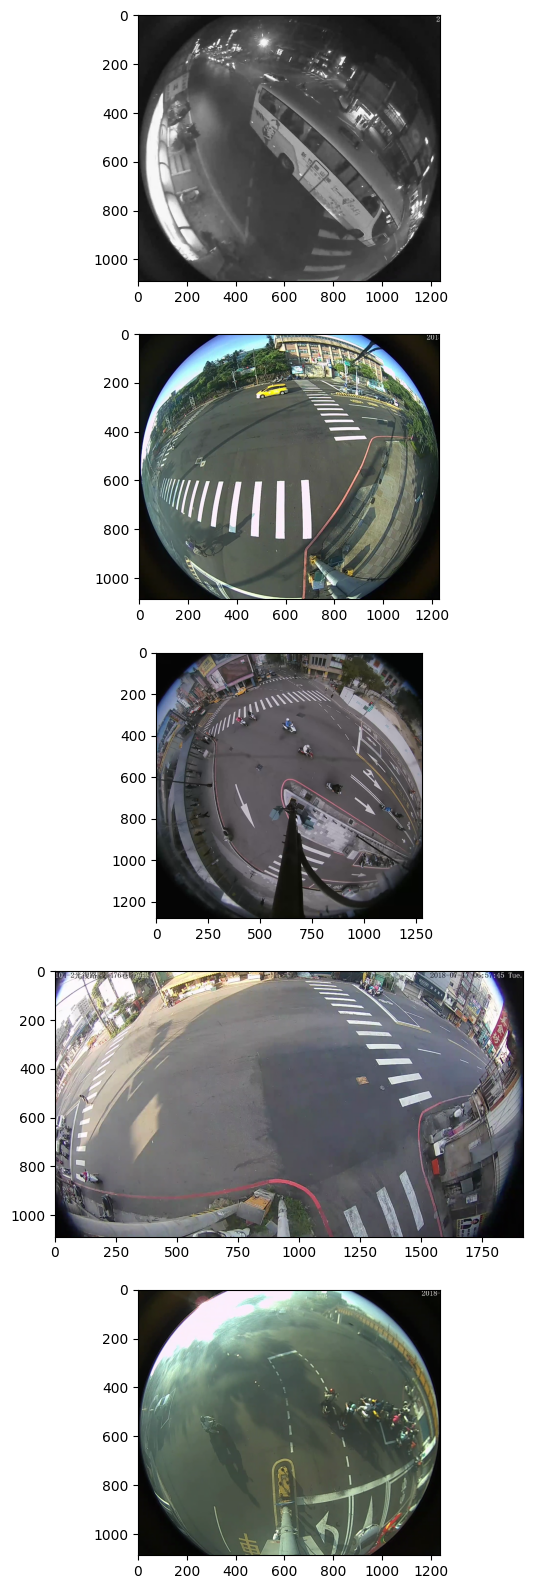

In [7]:
%matplotlib inline

imgs = os.listdir(TRAIN_PATH)
rand_imgs = np.random.choice(imgs, 5)

fig, ax = plt.subplots(5, 1, figsize=(10, 20))

for i, axes in enumerate(ax):
    img = np.array(Image.open(os.path.join(TRAIN_PATH, rand_imgs[i])))
    axes.imshow(img)

plt.show()

Loading dataset in COCO format

In [8]:
train_dataset = coco.CocoDetection(TRAIN_PATH, annFile=TRAIN_ANNOT)
test_dataset = coco.CocoDetection(TEST_PATH, annFile=TEST_ANNOT)

loading annotations into memory...
Done (t=0.55s)
creating index...
index created!
loading annotations into memory...
Done (t=0.30s)
creating index...
index created!


In [9]:
%matplotlib inline

def draw_bounding_box(img, bounding_box, label, color=(0, 0, 255)):

    draw = ImageDraw.Draw(img)
    font = ImageFont.load_default()
    label = str(label)

    x1, y1, w, h = bounding_box

    # draw rectangle
    draw.rectangle([x1, y1, x1 + w, y1 + h], outline=color, width=3)

    # label background
    # text_w, text_h = draw.textbbox(label, font=font, text=label)
    # # place above box, but not off image
    # ty = max(y1 - text_h - 2, 0)
    # draw.rectangle([x1, ty, x1 + text_w, ty + text_h], fill=color)

    # label text
    draw.text((x1, y1), label, fill='white', font=font)
    return img

In [10]:
%matplotlib inline

def draw_bounding_box_cv2(img, bounding_box, label, color=(0, 255, 0), other_format=True):

    if isinstance(img, torch.Tensor):
      img = img.permute(1,2,0).cpu().numpy()
      img = (img * 255).astype(np.uint8)
      img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    else:
      img = np.array(img)
      img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

    label = str(label)

    if other_format == True:
      x, y, w, h = bounding_box
      x2, y2 = int(x + w), int(y + h)
      x1, y1 = int(x), int(y)
    else:
      x1, y1, x2, y2 = bounding_box
      x1, y1 = int(x1), int(y1)
      x2, y2 = int(x2), int(y2)

    cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)

    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 0.5
    font_thickness = 1
    (text_w, text_h), baseline = cv2.getTextSize(label, font, font_scale, font_thickness)

    cv2.rectangle(
        img,
        (x1, y1 - text_h - baseline),
        (x1 + text_w, y1),
        color,
        thickness=cv2.FILLED
    )

    cv2.putText(
        img,
        label,
        (x1, y1 - baseline),
        font,
        font_scale,
        (255, 255, 255),
        font_thickness,
        lineType=cv2.LINE_AA
    )

    return img

Plotting target boxes on some random images

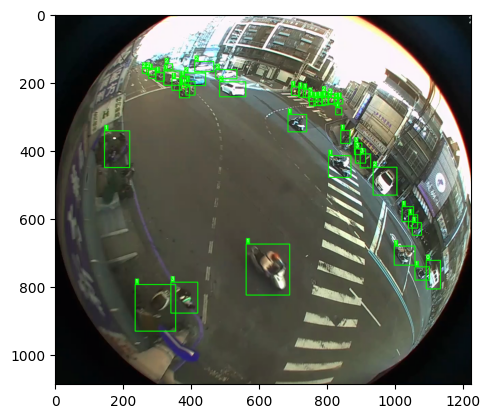

In [11]:
for img, lbls in train_dataset:
    new_img = img.copy()

    for lbl in lbls:
        bounding_box = lbl['bbox']
        text = lbl['category_id']

        new_img = draw_bounding_box_cv2(new_img, bounding_box, text)

    plt.imshow(new_img)
    plt.show()

    break

### Data preprocessing

In [12]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torch.optim import Adam, lr_scheduler
import torch.nn as nn
from tqdm import tqdm
from torch.utils.data import DataLoader
import gc
from torchvision.transforms import Compose, ToTensor
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [13]:
train_dataset = coco.CocoDetection(TRAIN_PATH, annFile=TRAIN_ANNOT, transform=Compose([ToTensor()]))
test_dataset = coco.CocoDetection(TEST_PATH, annFile=TEST_ANNOT, transform=Compose([ToTensor()]))

loading annotations into memory...
Done (t=0.48s)
creating index...
index created!
loading annotations into memory...
Done (t=0.11s)
creating index...
index created!


In [14]:
def custom_collate(batch):
    images, targets = list(zip(*batch))
    return images, targets

def load_data(batch_size):
  trainloader = DataLoader(
      train_dataset,
      batch_size=batch_size,
      shuffle=True,
      pin_memory=True,
      collate_fn=custom_collate
  )

  testloader = DataLoader(
      test_dataset,
      batch_size=batch_size,
      shuffle=False,
      pin_memory=True,
      collate_fn=custom_collate
  )

  return trainloader, testloader

In [15]:
trainloader, testloader = load_data(32)

In [16]:
label_map = {
    1: 3,
    2: 1,
    3: 2,
    6: 0,
    8: 4
}

In [17]:
def test_loop(model):
    model.eval()
    predicts = []

    with torch.no_grad():
        for img_batch, lbl_batch in tqdm(testloader):
            imgs = [imag.to(device) for imag in img_batch]
            y = model(imgs)

            for target, output in zip(lbl_batch, y):
                image_id = target["image_id"].item() if isinstance(target, dict) else target[0]['image_id']
                boxes = output["boxes"].cpu().tolist()
                scores = output["scores"].cpu().tolist()
                labels = output["labels"].cpu().tolist()

                for box, score, label in zip(boxes, scores, labels):
                  if score < 0.05:  # skip low-confidence
                      continue

                  if int(label) in label_map.keys():
                    cid = label_map[int(label)]

                    x1, y1, x2, y2 = box
                    width = x2 - x1
                    height = y2 - y1
                    predicts.append({
                        "image_id": image_id,
                        "category_id": cid,
                        "bbox": [x1, y1, width, height],
                        "score": score
                    })
    return predicts

### Loading model

In [18]:
def clear_memory(model):
    gc.collect()
    del model
    torch.cuda.empty_cache()

In [19]:
! pip install torchinfo

In [20]:
model1 = fasterrcnn_resnet50_fpn(
    pretrained=True,
    box_score_thresh=0.5,
    box_nms_thresh=0.5,
    box_detections_per_img=100,
)
model1 = model1.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [101]:
from torchinfo import summary

summary(
    model1,
    input_size=[(1, 3, 720, 1280)],
    col_names=["input_size", "output_size", "num_params", "trainable"],
    depth=2
)

Layer (type:depth-idx)                                  Input Shape               Output Shape              Param #                   Trainable
FasterRCNN                                              [1, 3, 720, 1280]         [0, 4]                    --                        Partial
├─GeneralizedRCNNTransform: 1-1                         [1, 3, 720, 1280]         [1, 3, 768, 1344]         --                        --
├─BackboneWithFPN: 1-2                                  [1, 3, 768, 1344]         [1, 256, 12, 21]          --                        Partial
│    └─IntermediateLayerGetter: 2-1                     [1, 3, 768, 1344]         [1, 2048, 24, 42]         23,454,912                Partial
│    └─FeaturePyramidNetwork: 2-2                       [1, 256, 192, 336]        [1, 256, 12, 21]          3,344,384                 True
├─RegionProposalNetwork: 1-3                            [1, 3, 768, 1344]         [1000, 4]                 --                        True
│    └─RPNHead:

Here we get predictions on test dataset using pretrained model itself

In [102]:
predicts = test_loop(model1)

100%|██████████| 85/85 [05:42<00:00,  4.03s/it]


### Evaluating predictions

We evaluate our predictions against labels using coco format

In [37]:
COCO_CLASSES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog',
    'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
    'N/A', 'dining table', 'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse',
    'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink',
    'refrigerator', 'N/A', 'book', 'clock', 'vase', 'scissors', 'teddy bear',
    'hair drier', 'toothbrush'
]

In [105]:
import json
import time

with open(f'output_{time.time()}.json', "w") as f:
    json.dump(predicts, f)
print(f"Saved {len(predicts)} predictions")

Saved 8858 predictions


In [106]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

coco_gt = COCO(TEST_ANNOT)
coco_dt = coco_gt.loadRes('output.json')
coco_eval = COCOeval(coco_gt, coco_dt, iouType="bbox")
coco_eval.params.catIds = list(label_map.values())

coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()

loading annotations into memory...
Done (t=0.11s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.38s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.71s).
Accumulating evaluation results...
DONE (t=0.45s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.038
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.067
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.039
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.009
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.026
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.121
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.033
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.049
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

We plot some of the predictions

In [129]:
idx = random.randint(0, len(test_dataset) - 1)
rand_img, rand_target = test_dataset[idx]

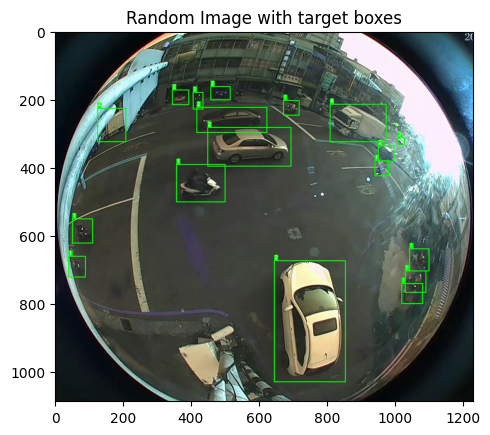

In [130]:
new_img = rand_img.clone()

for lbl in rand_target:
    bounding_box = lbl['bbox']
    text = lbl['category_id']

    new_img = draw_bounding_box_cv2(new_img, bounding_box, text)

new_img = cv2.cvtColor(new_img, cv2.COLOR_BGR2RGB)
plt.imshow(new_img)
plt.title('Random Image with target boxes')
plt.show()

In [131]:
model1.eval()
with torch.no_grad():
    output = model1([rand_img.to(device)])[0]

bicycle
bicycle
car
bicycle
bicycle


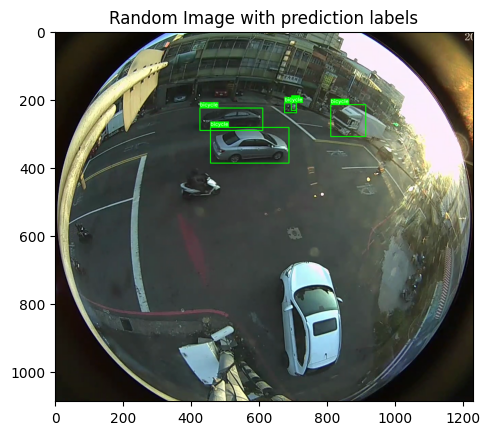

In [132]:
new_img = rand_img.clone()

for lbl, box in zip(output['labels'], output['boxes']):
    lbl = lbl.item()
    if lbl in label_map.keys():
      label_text = COCO_CLASSES[label_map[int(lbl)]]
      print(label_text)
      new_img = draw_bounding_box_cv2(new_img, box, label_text, other_format=False)

new_img = cv2.cvtColor(new_img, cv2.COLOR_BGR2RGB)
plt.imshow(new_img)
plt.title('Random Image with prediction labels')
plt.show()

From both images, we can see our model was able to detect desired objects from image. However, occluded objects are still not detected by our model

UniqueCountsResult(values=array([0, 1, 2, 3, 4]), counts=array([  98,   18, 5936, 2695,  111]))


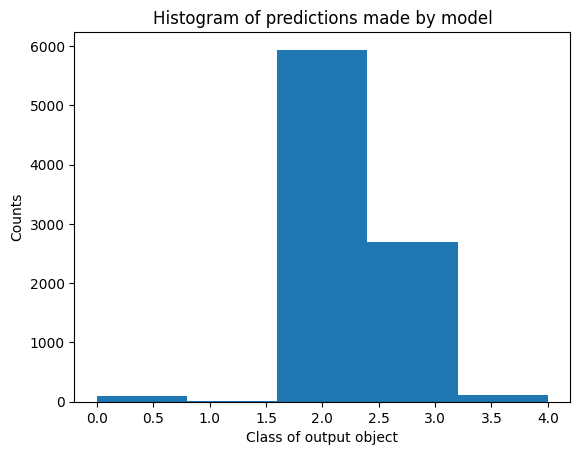

In [133]:
out_classes = [p['category_id'] for p in predicts]
hist_counts = np.unique_counts(np.array(out_classes))
print(hist_counts)

plt.hist(out_classes, bins=5)
plt.xlabel('Class of output object')
plt.ylabel('Counts')
plt.title('Histogram of predictions made by model')
plt.show()

## Method II
Predictions after training model on our dataset

Here we replace classifier in rcnn with our custom classifier with 6 output classes. Then we retrain our model

In [20]:
# 5 classes + 1 background
num_classes = 6
model2 = fasterrcnn_resnet50_fpn(
    pretrained=True,
    box_score_thresh=0.5,
    box_nms_thresh=0.5,
    box_detections_per_img=100,
)
input_features = model2.roi_heads.box_predictor.cls_score.in_features

model2.roi_heads.box_predictor = FastRCNNPredictor(input_features, num_classes)
model2 = model2.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Freezing roi layers & training rpn and backbone layers


In [21]:
for p in model2.backbone.parameters():
    p.requires_grad = False

for p in model2.roi_heads.parameters():
    p.requires_grad = True

for p in model2.rpn.parameters():
    p.requires_grad = False

In [22]:
# ! pip install torchinfo

In [23]:
from torchinfo import summary

summary(
    model2,
    input_size=[(1, 3, 720, 1280)],
    col_names=["input_size", "output_size", "num_params", "trainable"],
    depth=2
)

Layer (type:depth-idx)                                  Input Shape               Output Shape              Param #                   Trainable
FasterRCNN                                              [1, 3, 720, 1280]         [0, 4]                    --                        Partial
├─GeneralizedRCNNTransform: 1-1                         [1, 3, 720, 1280]         [1, 3, 768, 1344]         --                        --
├─BackboneWithFPN: 1-2                                  [1, 3, 768, 1344]         [1, 256, 12, 21]          --                        False
│    └─IntermediateLayerGetter: 2-1                     [1, 3, 768, 1344]         [1, 2048, 24, 42]         (23,454,912)              False
│    └─FeaturePyramidNetwork: 2-2                       [1, 256, 192, 336]        [1, 256, 12, 21]          (3,344,384)               False
├─RegionProposalNetwork: 1-3                            [1, 3, 768, 1344]         [1000, 4]                 --                        False
│    └─RPNHead: 2

Loading model's optimizers

In [24]:
train_params = [p for p in model2.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(train_params, lr=0.005, momentum=0.9, weight_decay=0.0005)
EPOCHS = 10
trainloader, testloader = load_data(48)

In [25]:
import gc

def train_loop(model):
    for e in range(EPOCHS):
        model.train()
        total_loss = 0

        with torch.set_grad_enabled(True):
            for img_batch, lbl_batch in tqdm(trainloader):
                imgs = [imag.to(device) for imag in img_batch]

                targets = []

                for annots in lbl_batch:
                    boxes = []
                    labels = []
                    for single_annot in annots:
                        out_box = single_annot['bbox']
                        label = single_annot['category_id']
                        if label not in label_map.keys():
                          continue

                        x, y, w, h = out_box[0], out_box[1], out_box[2], out_box[3]

                        if w > 0 and h > 0:
                            x1, y1, x2, y2 = x, y, x + w, y + h

                            boxes.append(torch.tensor([x1, y1, x2, y2], dtype=torch.float32))
                            labels.append(torch.tensor([label], dtype=torch.int64))


                    target = {
                        'boxes': torch.vstack(boxes).to(device),
                        'labels': torch.cat(labels, dim=0).to(device)
                    }
                    targets.append(target)

                loss_values = model(imgs, targets)
                loss = sum(l for l in loss_values.values())

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                total_loss += loss.item()

            print(f'Epoch: {e} | Train loss: {total_loss / len(train_dataset):.4f}')
            gc.collect()
            torch.cuda.empty_cache()

In [26]:
train_loop(model2)

100%|██████████| 111/111 [06:29<00:00,  3.51s/it]


Epoch: 0 | Train loss: 0.0575


100%|██████████| 111/111 [06:27<00:00,  3.49s/it]


Epoch: 1 | Train loss: 0.0530


100%|██████████| 111/111 [06:27<00:00,  3.49s/it]


Epoch: 2 | Train loss: 0.0519


100%|██████████| 111/111 [06:28<00:00,  3.50s/it]


Epoch: 3 | Train loss: 0.0512


100%|██████████| 111/111 [06:29<00:00,  3.51s/it]


Epoch: 4 | Train loss: 0.0508


100%|██████████| 111/111 [06:29<00:00,  3.51s/it]


Epoch: 5 | Train loss: 0.0504


 56%|█████▌    | 62/111 [03:39<02:53,  3.54s/it]


KeyboardInterrupt: 

In [ ]:
# clear_memory(model2)

In [27]:
torch.save(model2, "/content/gdrive/MyDrive/fasterrcnn_fisheye_full_better.pth")

In [28]:
# model2 = torch.load("fasterrcnn_fisheye_full_better.pth")
# model2.eval()

In [29]:
predicts2 = test_loop(model2)

100%|██████████| 57/57 [02:22<00:00,  2.49s/it]


In [30]:
import json
import time

with open(f'output2.json', "w") as f:
    json.dump(predicts2, f)
print(f"Saved {len(predicts2)} predictions")

Saved 22429 predictions


In [31]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

coco_gt = COCO(TEST_ANNOT)
coco_dt = coco_gt.loadRes('output2.json')
coco_eval = COCOeval(coco_gt, coco_dt, iouType="bbox")
coco_eval.params.catIds = list(label_map.values())

coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()

loading annotations into memory...
Done (t=0.33s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.09s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=4.65s).
Accumulating evaluation results...
DONE (t=0.64s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.002
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.001
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.005
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

In [36]:
COCO_CLASSES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog',
    'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
    'N/A', 'dining table', 'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse',
    'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink',
    'refrigerator', 'N/A', 'book', 'clock', 'vase', 'scissors', 'teddy bear',
    'hair drier', 'toothbrush'
]

We plot some of the predictions

In [46]:
idx = random.randint(0, len(test_dataset) - 1)
rand_img, rand_target = test_dataset[idx]

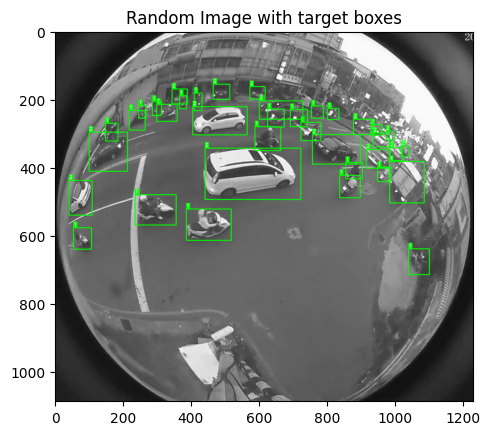

In [47]:
new_img = rand_img.clone()

for lbl in rand_target:
    bounding_box = lbl['bbox']
    text = lbl['category_id']

    new_img = draw_bounding_box_cv2(new_img, bounding_box, text)

new_img = cv2.cvtColor(new_img, cv2.COLOR_BGR2RGB)
plt.imshow(new_img)
plt.title('Random Image with target boxes')
plt.show()

In [48]:
model2.eval()
with torch.no_grad():
    output = model2([rand_img.to(device)])[0]

person
person
person
car
person
car
car
car
person
car
car
car
person
car
car
car
car
car


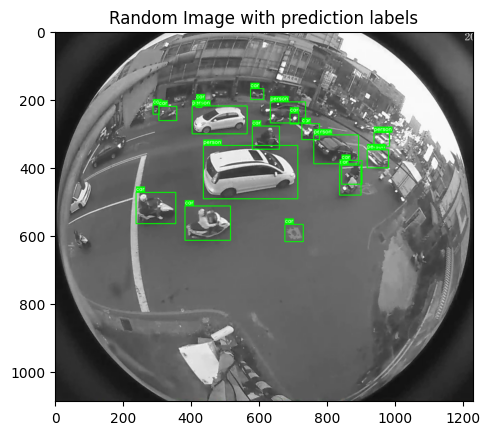

In [49]:
new_img = rand_img.clone()

for lbl, box in zip(output['labels'], output['boxes']):
    lbl = lbl.item()
    if lbl in label_map.keys():
      label_text = COCO_CLASSES[label_map[int(lbl)]]
      print(label_text)
      new_img = draw_bounding_box_cv2(new_img, box, label_text, other_format=False)

new_img = cv2.cvtColor(new_img, cv2.COLOR_BGR2RGB)
plt.imshow(new_img)
plt.title('Random Image with prediction labels')
plt.show()

From both images, we can see our model was able to detect desired objects from image. However, occluded objects are still not detected by our model

UniqueCountsResult(values=array([1, 2, 3]), counts=array([ 9831,   282, 12316]))


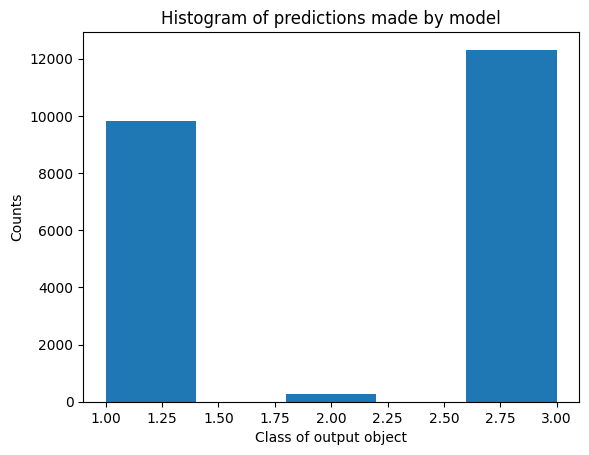

In [50]:
out_classes = [p['category_id'] for p in predicts2]
hist_counts = np.unique_counts(np.array(out_classes))
print(hist_counts)

plt.hist(out_classes, bins=5)
plt.xlabel('Class of output object')
plt.ylabel('Counts')
plt.title('Histogram of predictions made by model')
plt.show()

In [51]:
# clear_memory(model2)